## AI4MARS

In [1]:
from datasets import load_dataset

dataset = load_dataset("gustavv-andrzejewski/ai4mars-terrain-segmentation")

Generating train split:   0%|          | 0/18130 [00:00<?, ? examples/s]

Generating test_min1 split:   0%|          | 0/322 [00:00<?, ? examples/s]

Generating test_min2 split:   0%|          | 0/322 [00:00<?, ? examples/s]

Generating test_min3 split:   0%|          | 0/322 [00:00<?, ? examples/s]

### Exploration

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm

In [ ]:
train_ds = dataset["train"]

CLASS_LABELS = {0: "Soil", 1: "Bedrock", 2: "Sand", 3: "Big Rock", 255: "Null"}

CLASS_COLORS = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3: "#d62728", 255: "#7f7f7f"}

print(f"Dataset rows            : {len(train_ds):,}")
print(f"Columns                 : {train_ds.column_names}")
print(f"Samples with label mask : {sum(train_ds['has_labels']):,}")
print(f"Samples with rover mask : {sum(train_ds['has_masks']):,}")

▶ Dataset rows            : 18,130
▶ Columns                 : ['image', 'label_mask', 'rover_mask', 'range_mask', 'has_masks', 'has_labels']
▶ Samples with label mask : 16,064
▶ Samples with rover mask : 18,096


### samples

In [7]:

def to_np(img):
    """Convert HF Image feature or ndarray → np.ndarray (H, W, C)."""
    if img is None:
        return None
    if hasattr(img, "convert"):
        return np.array(img)          # PIL.Image
    if isinstance(img, np.ndarray):
        return img
    raise TypeError(f"Unsupported type: {type(img)}")

def terrain_legend(ax):
    handles = [
        mpatches.Patch(color=CLASS_COLORS[c], label=CLASS_LABELS[c])
        for c in sorted(CLASS_LABELS)
    ]
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.02, 1),
              borderaxespad=0., fontsize="small")

def apply_color_map(mask):
    """Convert class index mask to RGB color-coded image."""
    palette = np.zeros((256, 3), dtype=np.uint8)
    palette[0] = [31, 119, 180]   # Soil (blueish)
    palette[1] = [255, 127, 14]   # Bedrock (orange)
    palette[2] = [44, 160, 44]    # Sand (green)
    palette[3] = [214, 39, 40]    # Big Rock (red)
    palette[255] = [127, 127, 127] # Null (gray)

    rgb_mask = palette[mask]
    return rgb_mask

def show_sample(example, idx=None):
    """Display image, terrain mask with correct color mapping, rover and range masks."""
    img = to_np(example["image"])
    label_mask = to_np(example["label_mask"])
    rover_mask = to_np(example["rover_mask"])
    range_mask = to_np(example["range_mask"])

    fig, axs = plt.subplots(1, 4, figsize=(22, 6))

    axs[0].imshow(img)
    axs[0].set_title("Mars Image"); axs[0].axis('off')

    if label_mask is not None:
        label_rgb = apply_color_map(label_mask)
        axs[1].imshow(label_rgb)
        axs[1].set_title("Terrain Mask (Colored)")
        terrain_legend(axs[1])
    else:
        axs[1].set_title("Label Mask (Missing)"); axs[1].axis('off')

    if rover_mask is not None:
        axs[2].imshow(rover_mask, cmap="gray")
        axs[2].set_title("Rover Mask"); axs[2].axis('off')
    else:
        axs[2].set_title("Rover Mask (Missing)"); axs[2].axis('off')

    if range_mask is not None:
        axs[3].imshow(range_mask, cmap="gray")
        axs[3].set_title("Range Mask (>30m)"); axs[3].axis('off')
    else:
        axs[3].set_title("Range Mask (Missing)"); axs[3].axis('off')

    if idx is not None:
        fig.suptitle(f"Sample #{idx}", fontsize=16)

    plt.tight_layout()
    plt.show()

🔍 Displaying 3 labelled samples …


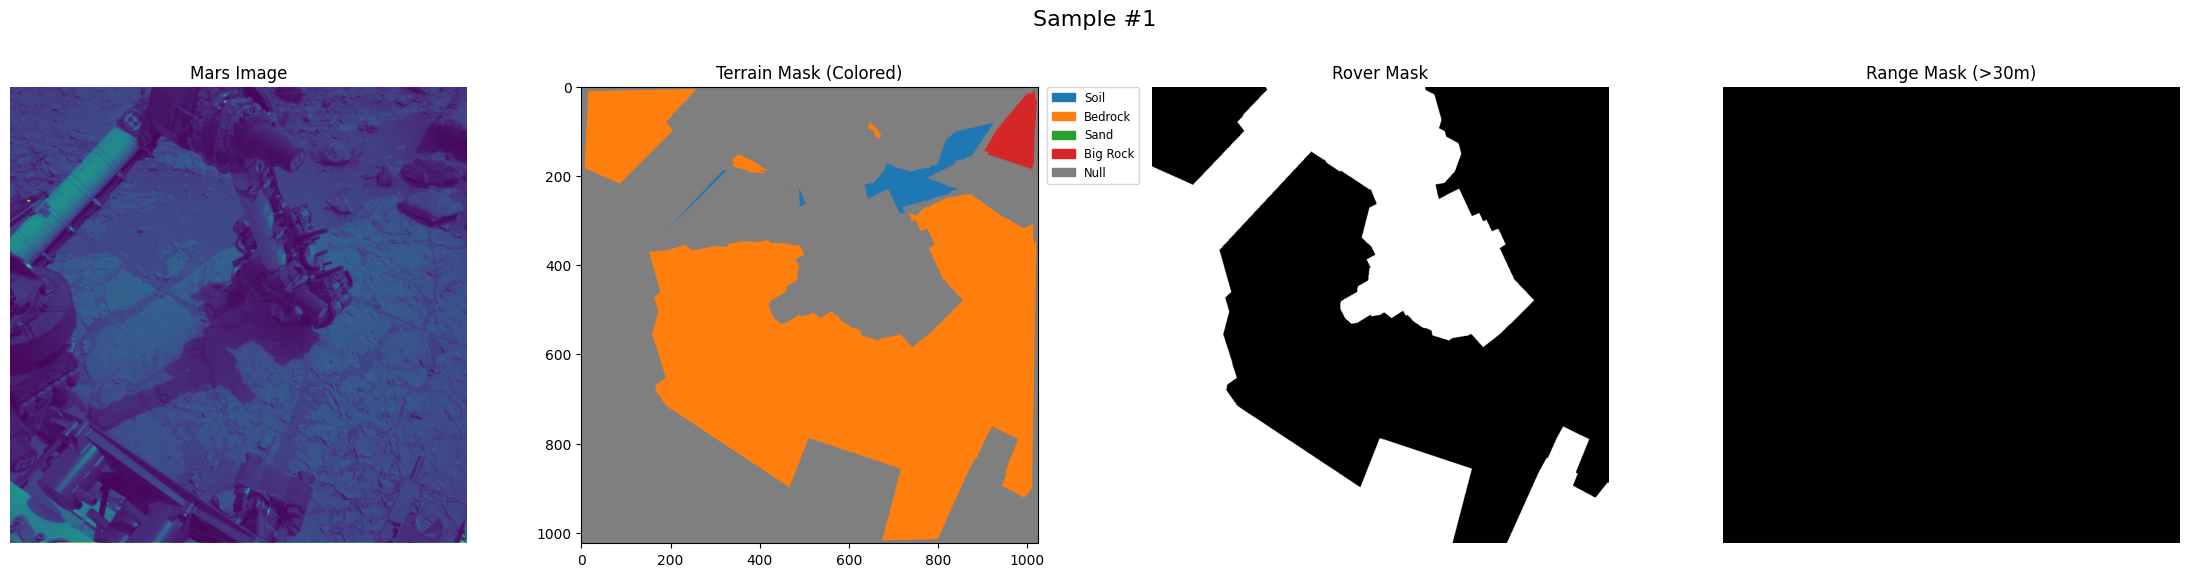

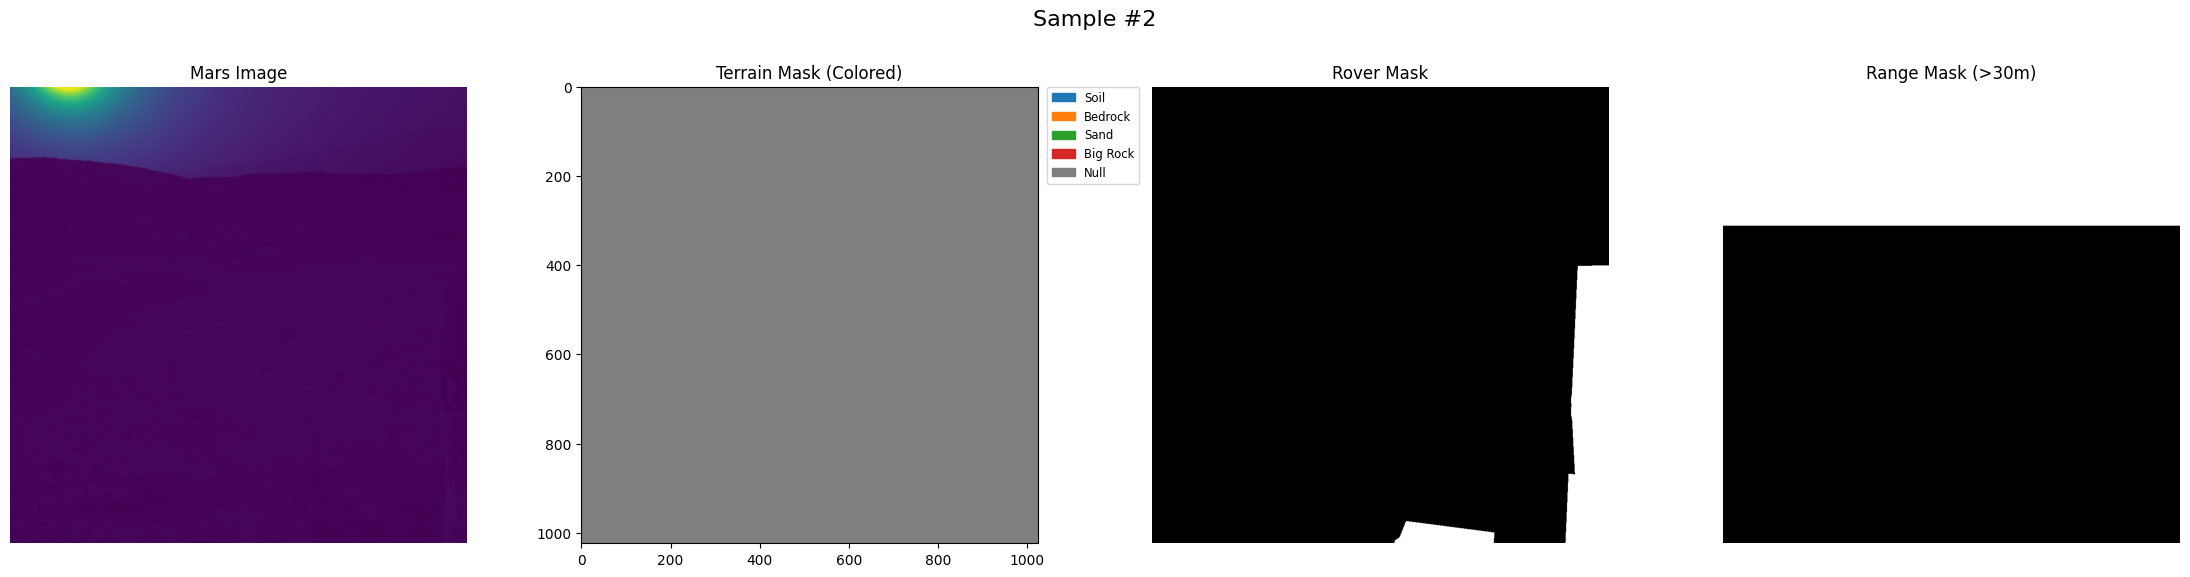

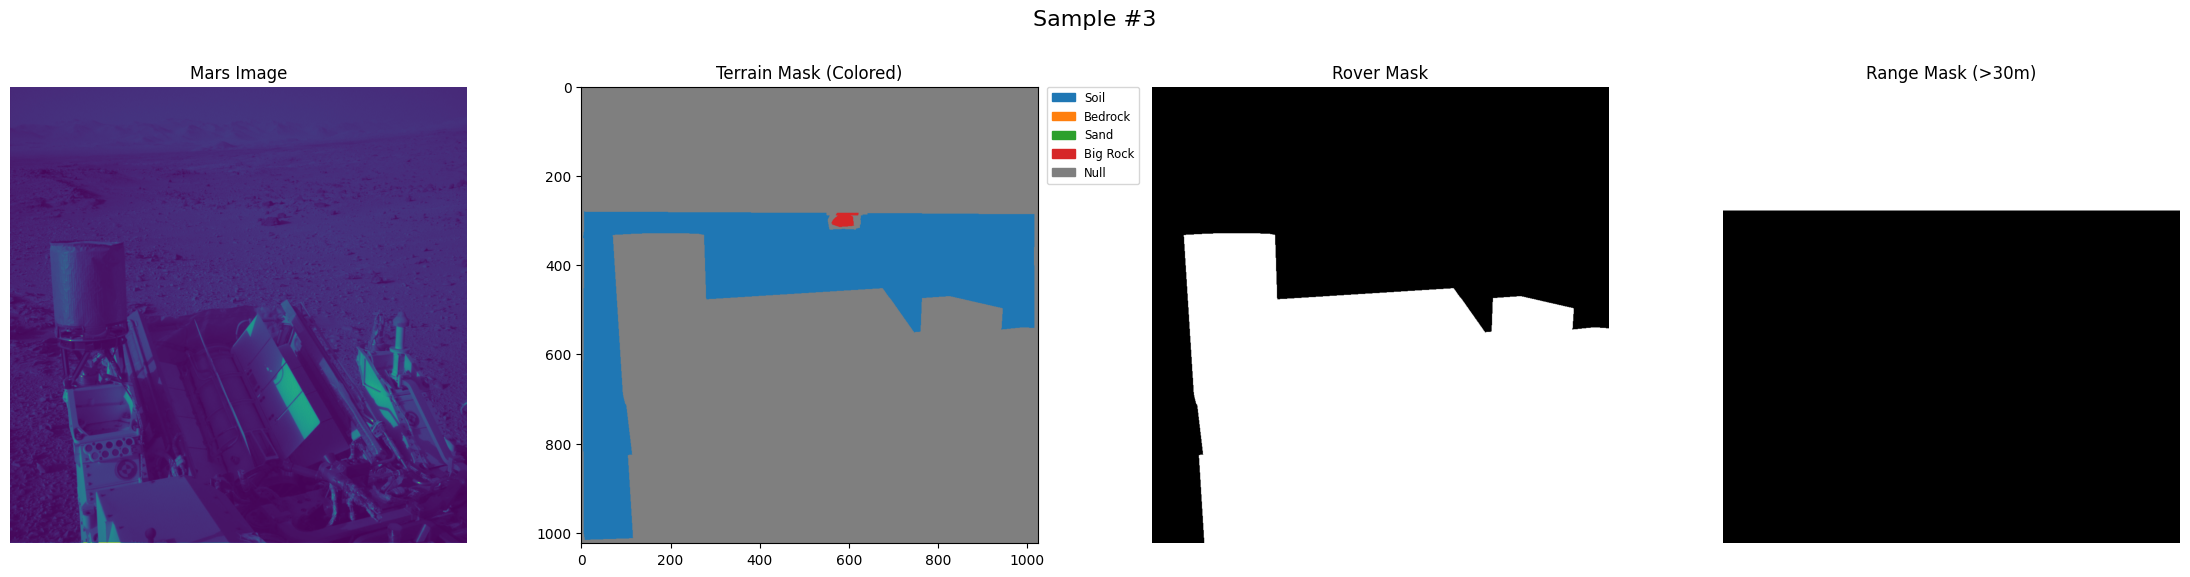

In [9]:
print("🔍 Displaying 3 labelled samples …")
shown = 0
for i, ex in enumerate(train_ds):
    if ex["has_labels"]:
        show_sample(ex, i)
        shown += 1
    if shown == 3:
        break


### Pixel-level Class Distribution


📊 Accumulating pixel stats on first 5000 label masks …


  0%|          | 0/5000 [00:00<?, ?it/s]

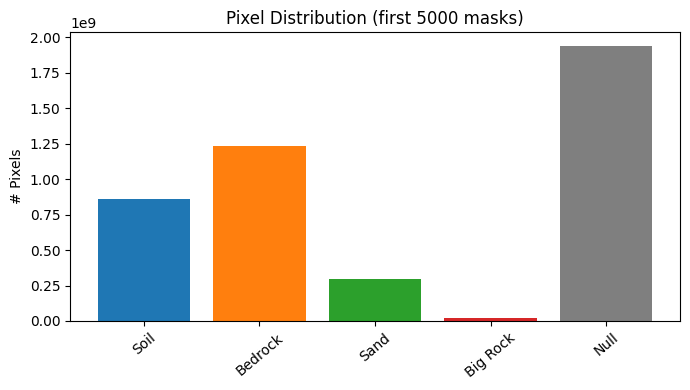

In [10]:
N_SAMPLES = 5000
print(f"Accumulating pixel stats on first {N_SAMPLES} label masks …")
hist = np.zeros(len(CLASS_LABELS), dtype=np.int64)

for ex in tqdm(train_ds.select(range(N_SAMPLES))):
    if not ex["has_labels"]:
        continue
    mask = to_np(ex["label_mask"])
    cls, cnt = np.unique(mask, return_counts=True)
    for c, n in zip(cls, cnt):
        if c in CLASS_LABELS:
            hist[list(CLASS_LABELS.keys()).index(c)] += n

plt.figure(figsize=(7, 4))
plt.bar(CLASS_LABELS.values(), hist, color=[CLASS_COLORS[k] for k in CLASS_LABELS])
plt.title(f"Pixel Distribution (first {N_SAMPLES} masks)")
plt.ylabel("# Pixels"); plt.xticks(rotation=40)
plt.tight_layout(); plt.show()


### Mask Coverage Check (% of NULL Pixels)

In [11]:
print("Computing average NULL pixel coverage...")
total_pixels = 0
null_pixels = 0

for ex in tqdm(train_ds.select(range(N_SAMPLES))):
    if not ex["has_labels"]:
        continue
    mask = to_np(ex["label_mask"])
    total_pixels += np.prod(mask.shape)
    null_pixels += np.sum(mask == 255)

null_ratio = null_pixels / total_pixels
print(f"Null pixels across dataset ≈ {null_ratio:.2%}")

Computing average NULL pixel coverage...


  0%|          | 0/5000 [00:00<?, ?it/s]

Null pixels across dataset ≈ 44.52%


### Rover Mask Coverage Check

In [12]:
print("Rover mask coverage statistics...")
rover_area_ratios = []

for ex in tqdm(train_ds.select(range(N_SAMPLES))):
    if not ex["has_masks"]:
        continue
    rover = to_np(ex["rover_mask"])
    if rover is not None:
        rover_area_ratios.append(np.mean(rover))

if rover_area_ratios:
    print(f"Average rover mask area: {np.mean(rover_area_ratios)*100:.2f}%")
    print(f"Max rover mask area observed: {np.max(rover_area_ratios)*100:.2f}%")
else:
    print("No rover masks available in first N samples.")


Rover mask coverage statistics...


  0%|          | 0/5000 [00:00<?, ?it/s]

Average rover mask area: 22.15%
Max rover mask area observed: 100.00%


### Image Brightness Distribution

Image brightness analysis...


  0%|          | 0/5000 [00:00<?, ?it/s]

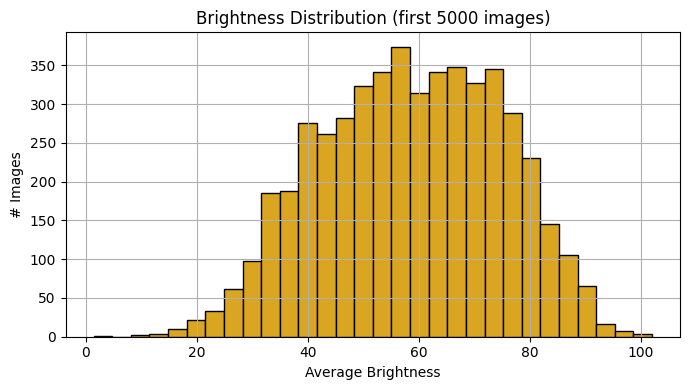

In [13]:
print("Image brightness analysis...")

avg_brightness = []

for ex in tqdm(train_ds.select(range(N_SAMPLES))):
    img = to_np(ex["image"])
    brightness = np.mean(img)
    avg_brightness.append(brightness)

plt.figure(figsize=(7,4))
plt.hist(avg_brightness, bins=30, color="goldenrod", edgecolor="black")
plt.title(f"Brightness Distribution (first {N_SAMPLES} images)")
plt.xlabel("Average Brightness")
plt.ylabel("# Images")
plt.grid(True)
plt.tight_layout()
plt.show()

## Augmentations

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

TARGET_SIZE = (224, 224)

train_transform = A.Compose([
    A.SmallestMaxSize(max_size=TARGET_SIZE[0] * 2, p=1.0),
    A.RandomCrop(height=TARGET_SIZE[0], width=TARGET_SIZE[1], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(std_range=(0.1, 0.2), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [18]:
val_transform = A.Compose([
    A.SmallestMaxSize(max_size=TARGET_SIZE[0] * 2, p=1.0),
    A.CenterCrop(height=TARGET_SIZE[0], width=TARGET_SIZE[1], p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


### test

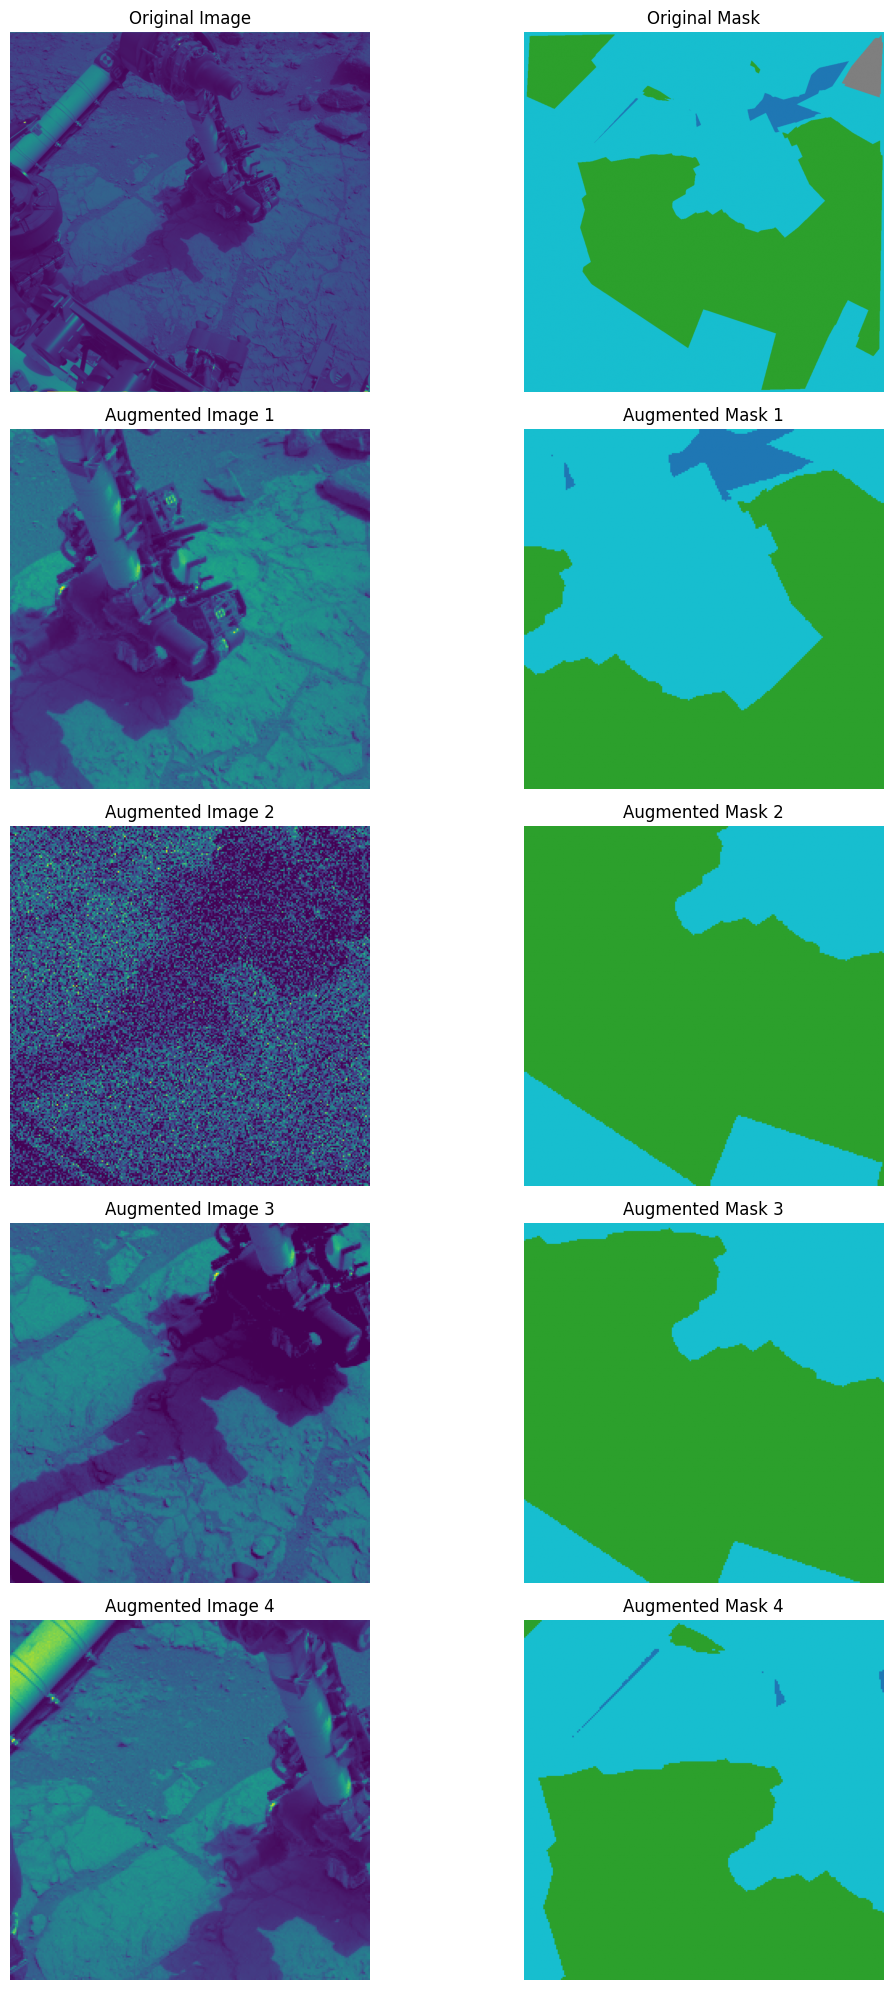

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

# Strip normalization and ToTensorV2 for visualization
def get_vis_transform(transform):
    if isinstance(transform, A.Compose):
        return A.Compose([
            t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))
        ])
    else:
        return None

# Apply transforms N times and plot
def visualize_augmented(img, mask, transform, samples=4):
    vis_transform = get_vis_transform(transform)

    # 1 extra row for original
    fig, ax = plt.subplots(samples + 1, 2, figsize=(12, (samples + 1) * 4))

    # Show original
    ax[0, 0].imshow(img)
    ax[0, 0].set_title("Original Image")
    ax[0, 0].axis('off')

    ax[0, 1].imshow(mask, cmap="tab10", vmin=0, vmax=4)
    ax[0, 1].set_title("Original Mask")
    ax[0, 1].axis('off')

    # Show augmentations
    for i in range(samples):
        augmented = vis_transform(image=img, mask=mask)
        aug_img = augmented["image"]
        aug_mask = augmented["mask"]

        ax[i + 1, 0].imshow(aug_img)
        ax[i + 1, 0].set_title(f"Augmented Image {i+1}")
        ax[i + 1, 0].axis('off')

        ax[i + 1, 1].imshow(aug_mask, cmap="tab10", vmin=0, vmax=4)
        ax[i + 1, 1].set_title(f"Augmented Mask {i+1}")
        ax[i + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Find a sample
for ex in train_ds:
    if ex["has_labels"]:
        example = ex
        break

img = np.array(example["image"])
mask = np.array(example["label_mask"])

# --- Usage
visualize_augmented(img, mask, train_transform, samples=4)


In [24]:
from datasets import load_dataset, Image
from PIL import Image as PILImage, UnidentifiedImageError
from io import BytesIO
from tqdm import tqdm

# Load with decoding disabled
ds = load_dataset("gustavv-andrzejewski/ai4mars-terrain-segmentation", split="train")
ds = ds.cast_column("image", Image(decode=False))

# Now manually try to open images
broken_indices = []

for idx, example in tqdm(enumerate(ds)):
    raw_bytes = example["image"]["bytes"]
    try:
        img = PILImage.open(BytesIO(raw_bytes))
        img.verify()   # check if image is broken without fully loading it
    except UnidentifiedImageError:
        broken_indices.append(idx)
    except Exception as e:
        print(f"Unexpected error at {idx}: {e}")
        broken_indices.append(idx)

print(f"Found {len(broken_indices)} broken images.")
print("Indices:", broken_indices)


18130it [05:27, 55.30it/s]

Found 3 broken images.
Indices: [8990, 12577, 17053]
